In [1]:
import numpy as np
import music21
from music21 import converter
# from music21 import stream
from music21.note import Note
from copy import deepcopy
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from utils import *

In [2]:
score = converter.parse('../scores/Summa.musicxml')
soprano, alto, tenor, bass = score.parts
soprano.color = 'C2'
alto.color = 'C0'
tenor.color = 'C1'
bass.color = 'C3'

## Annotate score

We use a diatonic pitch representation by numbering scale degrees:
```
1 = E2, 2 = F#2, 3 = G2, 4 = A3, ..., 8 = E3, 9 = F#3, ...
```

In [3]:
from music21.scale import MinorScale
scales = [MinorScale(tonic=f'E{octave}') for octave in range(2, 6)]
scale_pitches = [note.nameWithOctave for s in scales for note in s.getPitches()[:-1]]
pitch_to_step = { note: index + 1 for index, note in enumerate(scale_pitches)}
step_to_pitch = { index + 1: note for index, note in enumerate(scale_pitches)}

We represent score positions not by measure numbers but by syllable numbers. So we essentially ignore measure duration.

In [4]:
def is_melisma(note):
    """Return True if the note is a melisma"""
    return len(note.lyrics) == 0

def syllable_count(stream):
    """Count the number of syllables in a stream"""
    return len([note for note in stream.flat.notes if not is_melisma(note)])

In [5]:
def measure_length(score, measure_num):
    """Return the length of a measure in number of syllables"""
    measure = score.measure(measure_num)
    alto = measure.parts[1]
    bass = measure.parts[3]
    return max(syllable_count(alto), syllable_count(bass))

In [6]:
MEASURES = [measure_length(score, m.number) for m in alto.recurse(classFilter='Measure')]

In [7]:
def decorate_score(score):
    measure_start = 0
    rel_positions = [0, 0, 0, 0]
    for m in range(1, len(MEASURES) + 1):
        length = measure_length(score, m)
        for part_num, part in enumerate(score.parts):
            measure = part.measure(m)
            measure.editorial['length'] = length
            measure.editorial['start_position'] = measure_start
            measure.editorial['end_position'] = measure_start + length

            syllable_num = measure_start
            for note in measure.flat.notes:
                note.editorial['first_of_measure'] = syllable_num == measure_start
                note.editorial['melisma'] = is_melisma(note)
                note.editorial['syllable'] = syllable_num
                if not is_melisma(note):
                    syllable_num += 1
                    rel_positions[part_num] += 1
                    note.editorial['position'] = syllable_num
                    note.editorial['relative_position'] = rel_positions[part_num]
                else:
                    note.editorial['position'] = syllable_num + 0.5
                    note.editorial['relative_position'] = rel_positions[part_num] + 0.5
                    
        measure_start += length
        
decorate_score(score)

## Plotting

In [8]:
def decorate_notes(notes, melisma_indices):
    """Add relevant information to a sequence of notes"""
    syllables = 0
    for index, note in enumerate(notes):
        if index == 0: 
            note.editorial['first_of_measure'] = True
        else:
            note.editorial['first_of_measure'] = False
        
        if index in melisma_indices:
            note.editorial['melisma'] = True
            note.editorial['position'] = syllables - .5
            note.editorial['relative_position'] = syllables - .5
        else:
            note.editorial['melisma'] = False
            note.editorial['position'] = syllables
            note.editorial['relative_position'] = syllables
            syllables += 1

    return notes

# alto_pattern_pitches = 'D4 B3 C4 B3 A3 G3 B3 F#3 G3 E3 A3 B3 C4 B3 D4 E4 F#4 G4 F#4'.split()
# alto_pattern = [music21.note.Note(pitch) for pitch in alto_pattern_pitches]
# melisma_indices = [1, 6, 9, 13] 
# decorate_notes(alto_pattern, melisma_indices);
# print(get_coordinates(alto_pattern))
# show_stream(alto_pattern)

In [9]:
def get_coordinates(stream, skip_melismas=False, skip_breaks=False):
    positions = []
    steps = []
    melismas = []
    barlines = []
    
    if isinstance(stream, music21.stream.Stream):
        notes = stream.flat.notes
    else:
        notes = stream
        
    for i, note in enumerate(notes):
        if skip_melismas and note.editorial['melisma']: continue
        steps.append(pitch_to_step[note.pitch.nameWithOctave])
        if skip_breaks:
            positions.append(note.editorial['relative_position'])
        else:
            positions.append(note.editorial['position'])
        melismas.append(note.editorial['melisma'])
        if note.editorial['first_of_measure']:
            barlines.append(i)
    
    barlines.append(i+1)
    
    return np.array(positions), np.array(steps), np.array(melismas), np.array(barlines)

# xs, ys, _, _ = get_coordinates(alto.measures(1, 3), skip_melismas=True)
# xs, ys, _, _ = get_coordinates(alto.recurse(classFilter='Note')[:10], skip_melismas=True)
get_coordinates(alto.measures(48, 49))

(array([362. , 363. , 363.5, 364. , 365. , 365.5, 365.5, 365.5, 366. ]),
 array([12, 13, 12, 14, 15, 16, 17, 16, 15]),
 array([False, False,  True, False, False,  True,  True,  True, False]),
 array([0, 8, 9]))

In [10]:
def plot_interp(xs, ys, *args, size=100, kind='linear', ax=None, interpolate=False, **kwargs):
    if ax is None: ax = plt.gca()
    if len(xs) > 1 and interpolate:
        f = interp1d(xs, ys, kind=kind)
        _xs = np.linspace(xs[0], xs[-1], size)
        ax.plot(_xs, f(_xs), *args, **kwargs)
    else:
        ax.plot(xs, ys, *args, **kwargs)

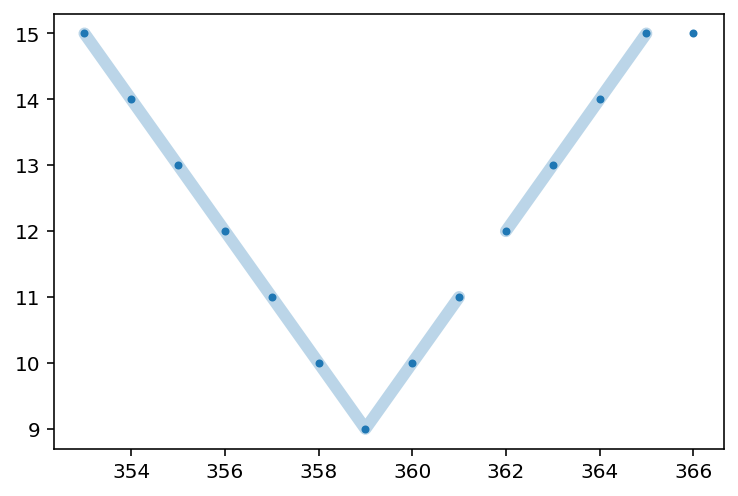

In [11]:
def show_stream(stream, ax=None, color='C4',
         skip_breaks=False,
         notes_interpolation='linear',
         plot_notes=True, note_plot_kws=dict(),
         mark_notes=True, note_mark_kws=dict(),
         plot_melismas=True, melisma_plot_kws=dict(),
         mark_melismas=False, melisma_mark_kws=dict(),
         melisma_interpolation='linear',
         adjust_x=0, adjust_y=0):
    """"""
    if ax is None: ax = plt.gca()
    
    # Get coordinates for all notes
    all_xs, all_ys, all_melismas, barlines = get_coordinates(stream, skip_breaks=skip_breaks)

    # Don't break the plot when skip_breaks is True
    if skip_breaks: 
        barlines = [0, barlines[-1]]

    # Break the plots per bar
    for a, b in zip(barlines, barlines[1:]):
        xs = all_xs[a:b] + adjust_x
        ys = all_ys[a:b] + adjust_y
        melismas = all_melismas[a:b]
        
        # Normal notes: plot and markers
        if plot_notes:
            kwargs = dict(ls='-', c=color, alpha=.3, lw=6)
            kwargs.update(note_plot_kws)
            plot_interp(xs[melismas == False], ys[melismas == False], zorder=100, ax=ax, kind=notes_interpolation, **kwargs)
            
        if mark_notes:
            kwargs = dict(marker='.', c=color)
            kwargs.update(note_mark_kws)
            ax.scatter(xs[melismas==False], ys[melismas==False], zorder=100, marker='.', c=color)
    
        # Melismas: plot and markers
        if plot_melismas: 
            kwargs = dict(lw=.5, c=color, ls='-')
            kwargs.update(melisma_plot_kws)
            plot_interp(xs, ys, zorder=100, ax=ax, kind=melisma_interpolation, **kwargs)
        
        if mark_melismas:
            kwargs = dict(marker='+', color=color)
            kwargs.update(melisma_mark_kws)
            ax.scatter(xs[melismas==True], ys[melismas==True], zorder=100, **kwargs)

            
show_stream(alto.measures(47, 49), color=alto.color, plot_melismas=False)
# show_stream(alto.measures(1, 2), color=alto.color, skip_breaks=False, melisma_interpolation='previous')
# show_stream(bass.measures(1, 6), color=bass.color, skip_breaks=False, plot_melismas=True, 
#             mark_melismas=True, note_plot_kws=dict(lw=10),
#             melisma_mark_kws=dict(marker='x'))

## Plot melodic voices

In [12]:
plt.rcParams['lines.solid_capstyle'] = 'round'

def despine(ax=None):
    if ax is None: ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

def show_measures(ax=None, grid=True):
    if ax is None: ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    barlines = np.cumsum([0] + MEASURES) + .5
    ax.set_xticks(barlines)
    ax.set_xticklabels(np.arange(1, len(barlines)+1), color='0.5')
    if grid:
        ax.xaxis.set_tick_params(length=0)
        ax.grid(axis='x', c='0.9', zorder=1) 
    ax.set_xlim(x_min, x_max)

def show_octaves(ax=None, grid=True, octaves=[2, 3, 4, 5]):
    if ax is None: ax = plt.gca()
    y_min, y_max = ax.get_ylim()
    labels = [f'E{octave}' for octave in octaves]
    ticks = [pitch_to_step[label] for label in labels]
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    if grid:
        ax.yaxis.set_tick_params(length=0)
        ax.grid(axis='y', c='0.85', zorder=1, dashes=(5, 10)) 
    ax.set_ylim(y_min, y_max)

def show_sections(ax=None, color='0.5'):
    if ax is None: ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    barlines = np.cumsum([0] + MEASURES) + .5
    box_style = dict(boxstyle="round,pad=0.3", fc="white", ec=color, lw=.5)
    for section, m in enumerate(range(0, len(barlines), 3)):
        x = barlines[m]
        text = plt.annotate(section + 1, 
                            xy=(x, y_max), xytext=(0, 5),
                            textcoords='offset points',
                            ha='center', color=color, bbox=box_style)
    ax.set_xlim(x_min, x_max)

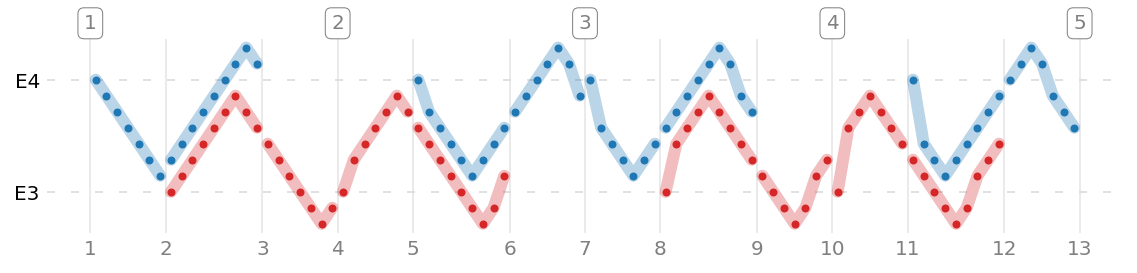

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2), tight_layout=True)

show_stream(alto.measures(1, 12), color=alto.color, plot_melismas=False)
show_stream(bass.measures(1, 12), color=bass.color, plot_melismas=False)
show_measures()
despine()
show_octaves()
show_sections()
plt.tight_layout()

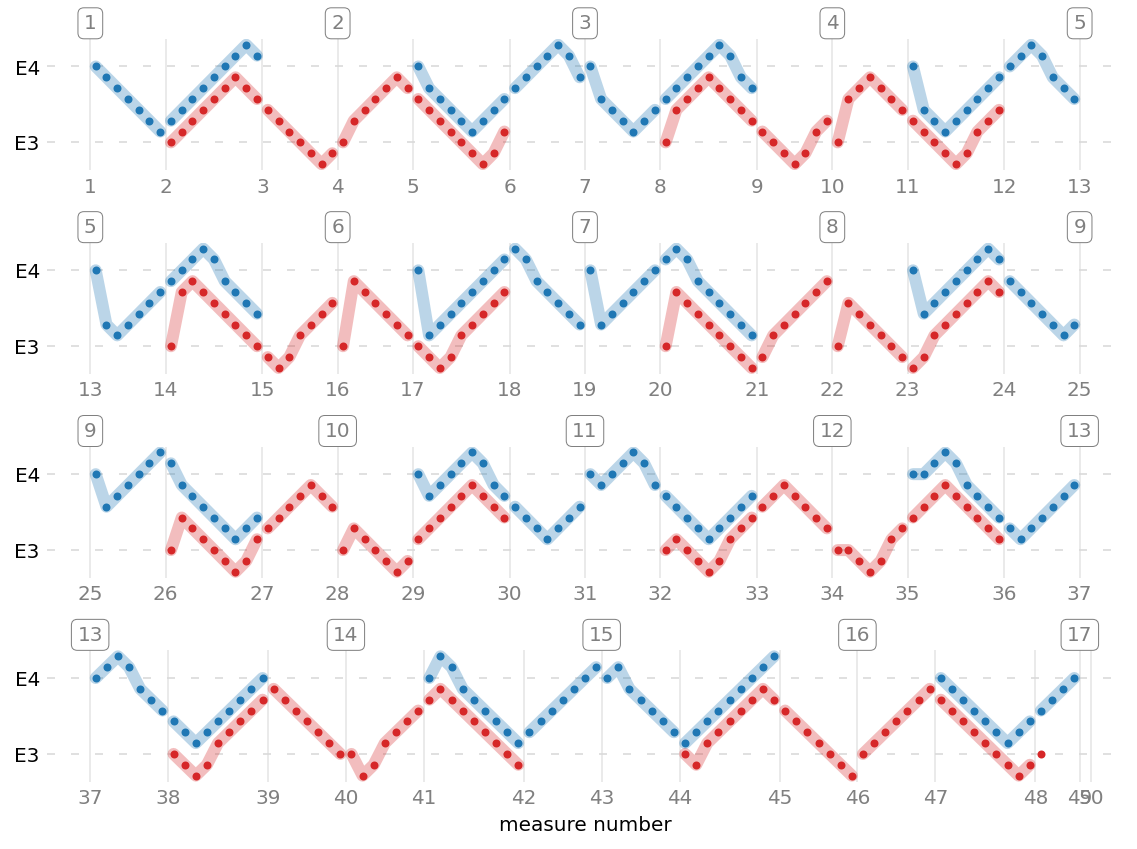

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(8, 6), tight_layout=True)

def fig1_subplot(start, end, ax):
    plt.sca(ax)
    show_stream(alto.measures(start, end), color=alto.color, plot_melismas=False)
    show_stream(bass.measures(start, end), color=bass.color, plot_melismas=False)
    show_measures()
    despine()
    show_octaves()
    show_sections()
    
fig1_subplot(1, 12, axs[0])
fig1_subplot(13, 24, axs[1])
fig1_subplot(25, 36, axs[2])
fig1_subplot(37, 48, axs[3])
plt.xlabel('measure number')

plt.savefig('../figures/melodic-voices/melodic-voices-raw.pdf')

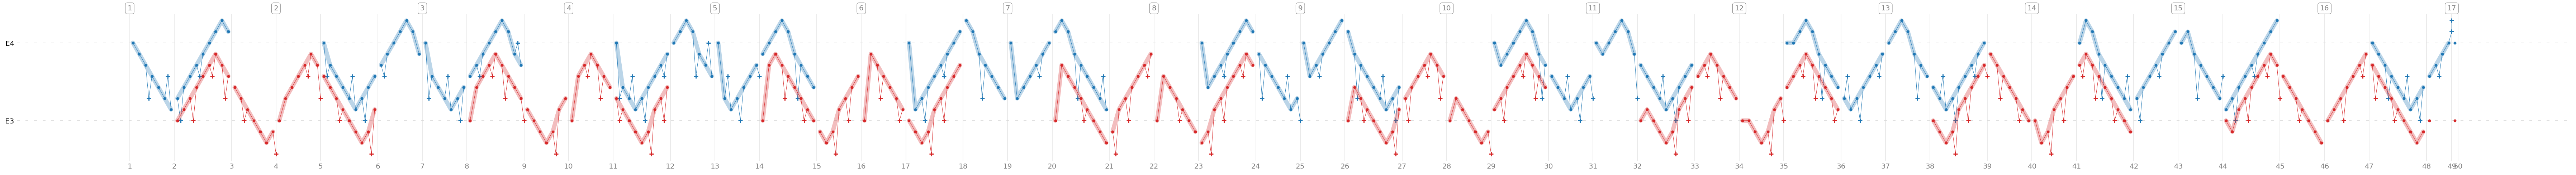

In [15]:
fig, ax = plt.subplots(1, figsize=(50, 3.5), tight_layout=True)

start = 1
end = 100
plt.sca(ax)
show_stream(alto.measures(start, end), color=alto.color, mark_melismas=True)
show_stream(bass.measures(start, end), color=bass.color, mark_melismas=True)
show_measures()
despine()
show_octaves()
show_sections()
plt.savefig('../figures/melodic-voices/melodic-voices-horizontal.pdf')

## Plot score without breaks

### Plotting functions

In [16]:
def get_measures_skip_breaks(alto=True, bass=False):
    """Get positions of measures when breaks are skipped"""
    if bass: alto = False
    if alto: bass = True
    
    if alto:
        measure_lengths = [7, 9, None, None, 9, 7]
    else:
        measure_lengths = [None, 9, 7, 7, 9, None]
    
    measure = 1
    measure_numbers = []
    rel_position = 1
    rel_positions = [rel_position]
    for i in range(8):
        for length in measure_lengths:
            if length is not None:
                rel_position += length
                measure_numbers.append(measure)
                rel_positions.append(rel_position)
            measure += 1
    measure_numbers.append(measure)
            
    return np.array(rel_positions), np.array(measure_numbers)
        
# ticks, labels = get_measures_skip_breaks(bass=True)

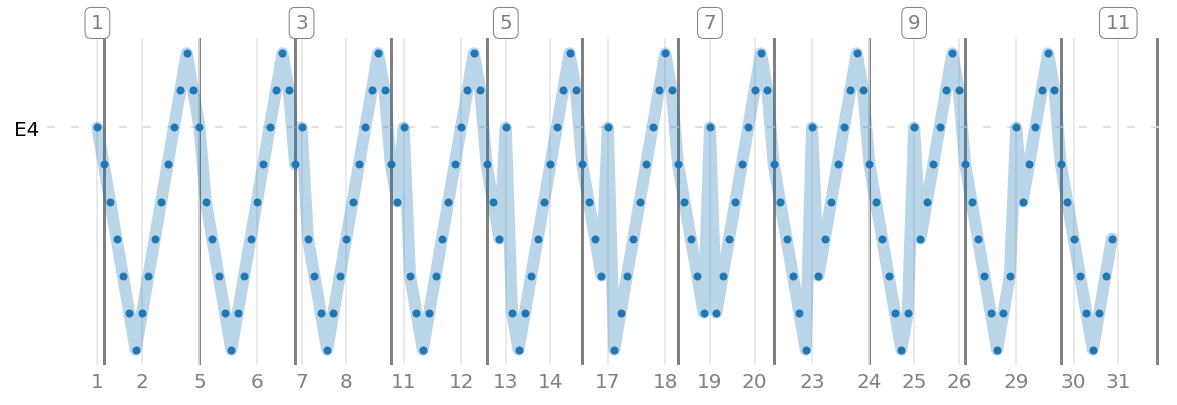

In [17]:
def show_repeats(ax=None, start=0, period=15, **kwargs):
    """Show regularly spaced lines to indicate when a pattern is repeated"""
    if ax is None: ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    kws = dict(c='0.5')
    kws.update(kwargs)
    repeats = np.arange(start, sum(MEASURES), period)
    for repeat in repeats:
        ax.axvline(repeat, zorder=1, **kws)
    ax.set_xlim(x_min, x_max)

def show_sections_without_breaks(alto=None, bass=None, ax=None, color='0.5'):
    """Show section numbers when breaks are skipped"""
    if ax is None: ax = plt.gca()
    if bass: alto = False
    if alto: bass = True
    
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    start = 1 if alto else 7+9 + 1
    section_positions = range(start, sum(MEASURES), 7 + 9 + 9 + 7)
    
    for s, x in enumerate(section_positions):
        box_style = dict(boxstyle="round,pad=0.3", fc="white", ec=color, lw=.5)
        section = s * 2 + 1 if alto else s * 2 + 2
        text = ax.annotate(section, 
                            xy=(x, y_max), xytext=(0, 5),
                            textcoords='offset points',
                            ha='center', color=color, bbox=box_style)
    ax.set_xlim(x_min, x_max)

def show_measures_without_breaks(alto=True, bass=False, ax=None, grid=True):
    """Show measures when breaks are skipped"""
    if ax is None: ax = plt.gca()
    x_min, x_max = ax.get_xlim()
    ticks, labels = get_measures_skip_breaks(alto=alto, bass=bass)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, color='0.5')
    if grid:
        ax.xaxis.set_tick_params(length=0)
        ax.grid(axis='x', c='0.9', zorder=1) 
    ax.set_xlim(x_min, x_max)
    
    
plt.figure(figsize=(10, 3))
show_stream(alto.measures(1, 30), color=alto.color, 
            skip_breaks=True, plot_melismas=False)
despine()
show_octaves()
show_repeats(start=2)
show_sections_without_breaks(alto=True)
show_measures_without_breaks(alto=True)

### Melodic voices

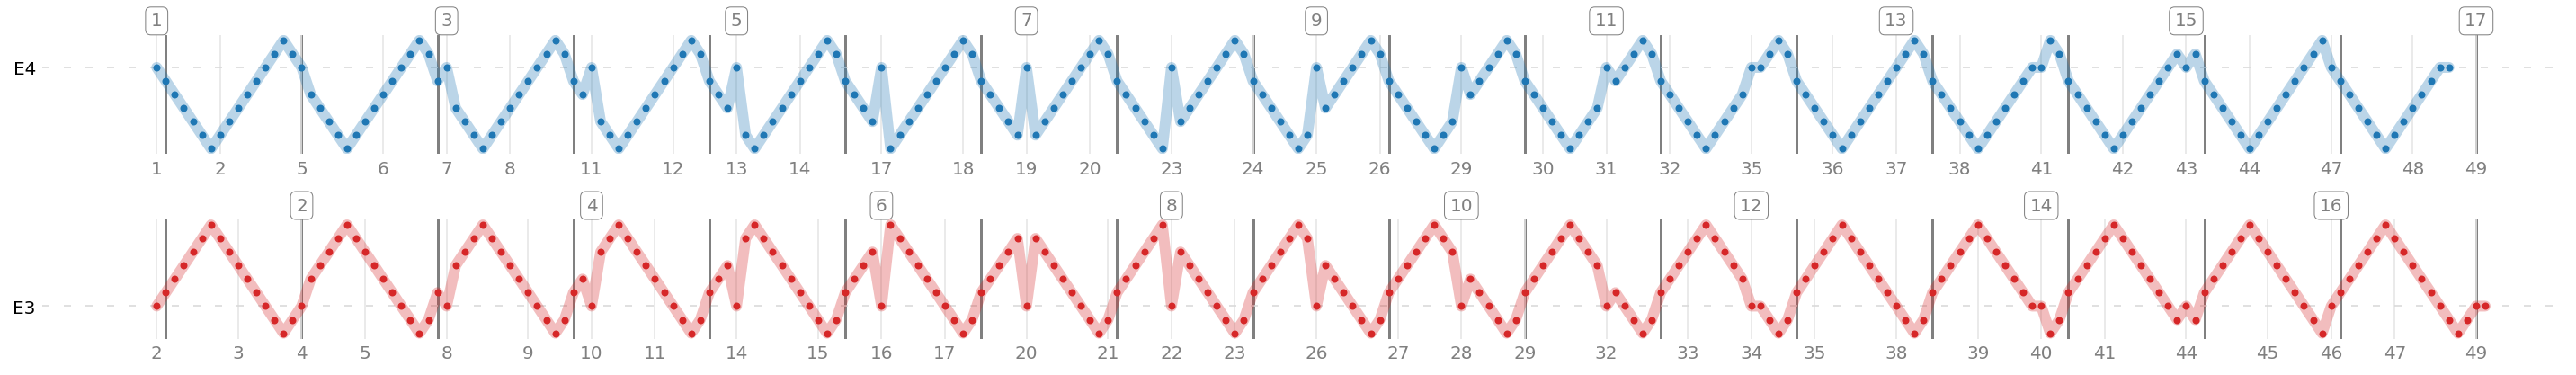

In [18]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 3), tight_layout=True)

show_stream(alto.measures(1, 50), color=alto.color, 
            skip_breaks=True, plot_melismas=False, ax=ax0)
despine(ax=ax0)
show_octaves(ax=ax0)
show_repeats(start=2, ax=ax0)
show_sections_without_breaks(alto=True, ax=ax0)
show_measures_without_breaks(alto=True, ax=ax0)

show_stream(bass.measures(1, 50), color=bass.color, 
            skip_breaks=True, plot_melismas=False, ax=ax1)
despine(ax=ax1)
show_octaves(ax=ax1)
show_repeats(start=2, ax=ax1)
show_sections_without_breaks(bass=True, ax=ax1)
show_measures_without_breaks(bass=True, ax=ax1)
ax1.set_xlim(*ax0.get_xlim());

plt.savefig('../figures/others/melodic-voices-without-breaks.pdf')

### All voices

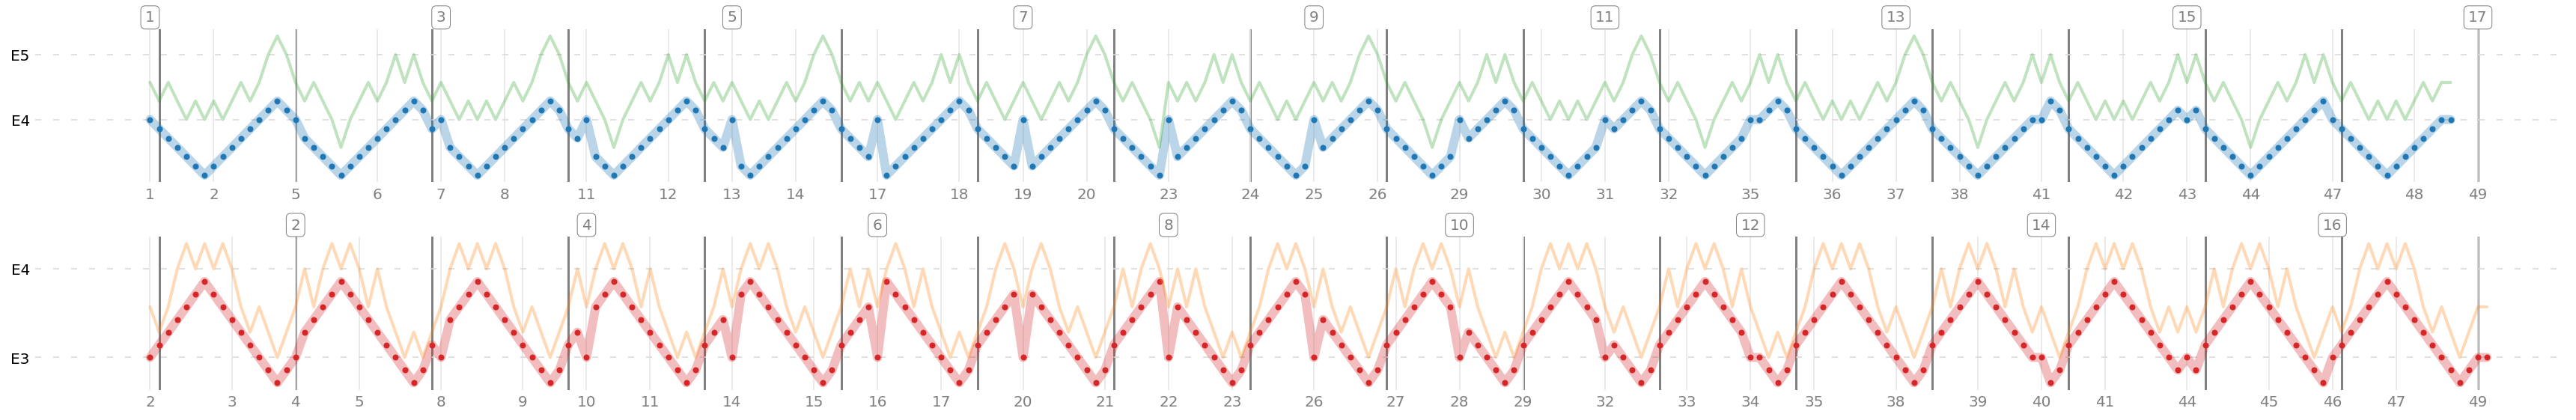

In [19]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(24, 4), tight_layout=True)

show_stream(alto.measures(1, 50), color=alto.color, 
            skip_breaks=True, plot_melismas=False, ax=ax0)
show_stream(soprano.measures(1, 50), color=soprano.color, 
            skip_breaks=True, plot_melismas=False, ax=ax0,
           note_plot_kws=dict(lw=2), mark_notes=False)
despine(ax=ax0)
show_octaves(ax=ax0)
show_repeats(start=2, ax=ax0)
show_sections_without_breaks(alto=True, ax=ax0)
show_measures_without_breaks(alto=True, ax=ax0)

show_stream(bass.measures(1, 50), color=bass.color, 
            skip_breaks=True, plot_melismas=False, ax=ax1)
show_stream(tenor.measures(1, 50), color=tenor.color, 
            skip_breaks=True, plot_melismas=False, ax=ax1,
            note_plot_kws=dict(lw=2), mark_notes=False)
despine(ax=ax1)
show_octaves(ax=ax1)
show_repeats(start=2, ax=ax1)
show_sections_without_breaks(bass=True, ax=ax1)
show_measures_without_breaks(bass=True, ax=ax1)
ax1.set_xlim(*ax0.get_xlim());

plt.savefig('../figures/others/all-voices-without-breaks-and-ornaments.pdf')

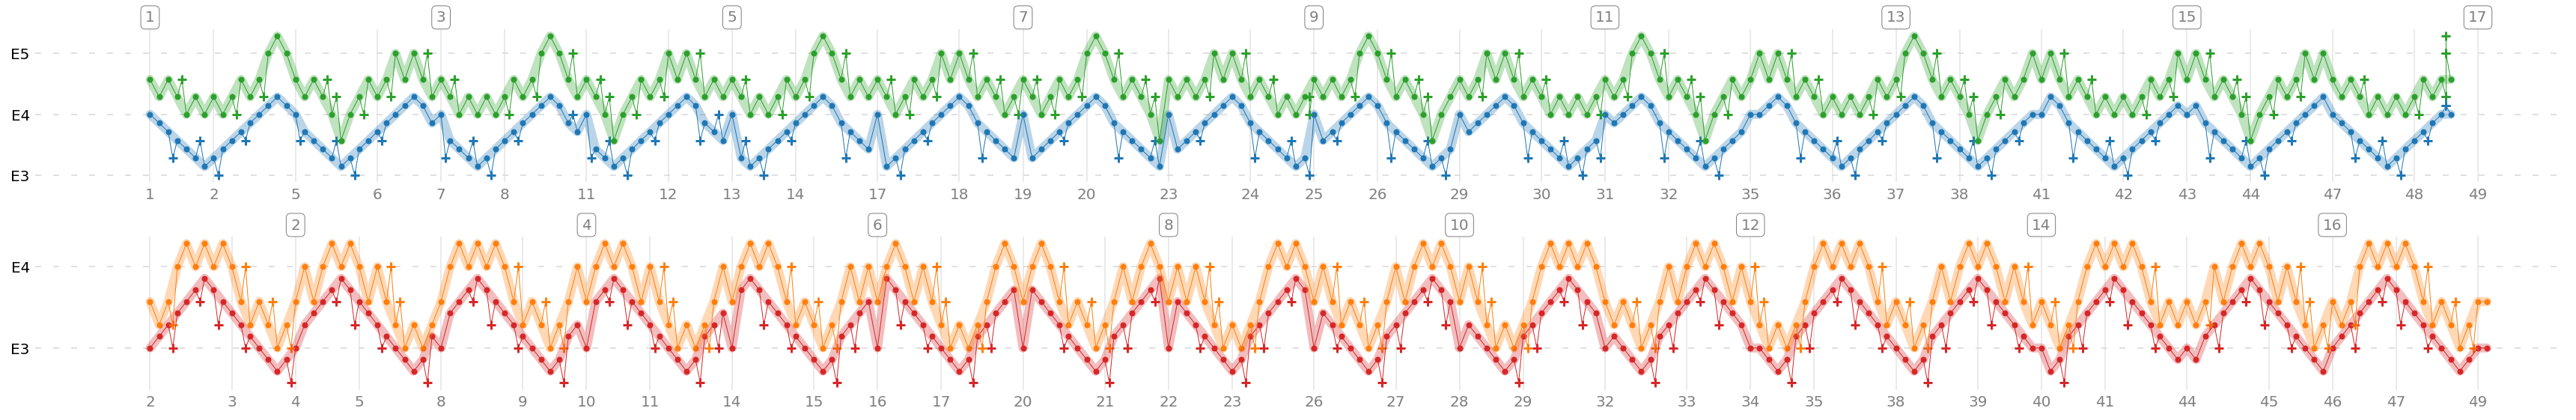

In [20]:
N = 50
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(24, 4), tight_layout=True)

kws = dict(mark_melismas=True, mark_notes=True, plot_melismas=True, skip_breaks=True)

show_stream(alto.measures(1, N), color=alto.color, ax=ax0, **kws)
show_stream(soprano.measures(1, N), color=soprano.color, ax=ax0, **kws)
despine(ax=ax0)
show_octaves(ax=ax0)
show_sections_without_breaks(alto=True, ax=ax0)
show_measures_without_breaks(alto=True, ax=ax0)

show_stream(bass.measures(1, N), color=bass.color, ax=ax1, **kws) 
show_stream(tenor.measures(1, N), color=tenor.color, ax=ax1, **kws) 
despine(ax=ax1)
show_octaves(ax=ax1)
show_sections_without_breaks(bass=True, ax=ax1)
show_measures_without_breaks(bass=True, ax=ax1)
ax1.set_xlim(*ax0.get_xlim());

plt.savefig('../figures/others/all-voices-without-breaks.pdf')

## Approximate patterns

### Melodic voices

In [21]:
alto_pattern_pitches = 'D4 G3 C4 B3 A3 G3 B3 F#3 G3 E3 A3 B3 C4 B3 D4 E4 F#4 G4 F#4'.split()
alto_pattern = [music21.note.Note(pitch) for pitch in alto_pattern_pitches]
melisma_indices = [1, 6, 9, 13] 
decorate_notes(alto_pattern, melisma_indices);
# music21.stream.Stream(alto_pattern).show()

In [22]:
bass_pattern_pitches = 'F#3 G3 E3 A3 B3 C4 B3 D4 C4 G3 B3 A3 G3 E3 F#3 E3 D3 C3 D3 B2'.split()
bass_pattern = [music21.note.Note(pitch) for pitch in bass_pattern_pitches]
melisma_indices = [2, 6, 9, 13, 19]
decorate_notes(bass_pattern, melisma_indices);
# music21.stream.Stream(bass_pattern).show()

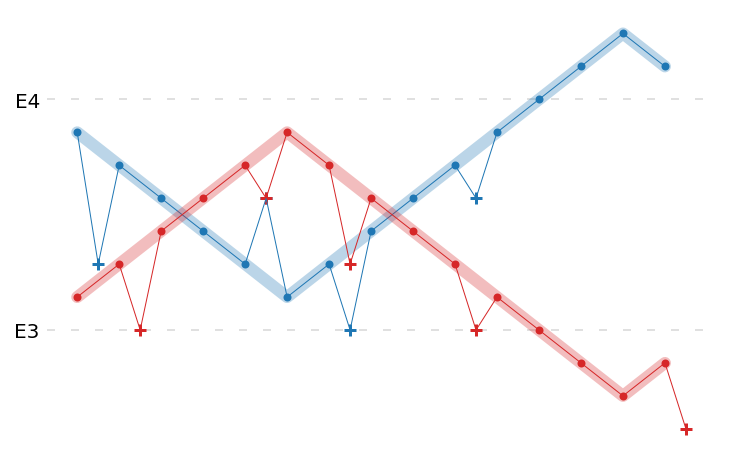

In [23]:
show_stream(alto_pattern, color=alto.color, mark_melismas=True)
show_stream(bass_pattern, color=bass.color, mark_melismas=True)
show_octaves()
despine()
plt.xticks([]);
plt.savefig('../figures/melodic-pattern/melodic-pattern-raw.pdf')

### Tenor

In [24]:
tenor_pattern_pitches  = 'G3 E3 B3 E4 G4 E4 G4 E4 G4 E4 B3 E4 G3 B3 G3 B3 E3 G3 E3 '
tenor_pattern_pitches += 'B3 E4 B3 E4 G4 E4 G4 E4 B3 E4 B3 E4 G3 B3 E3 G3 E3'
tenor_pattern_pitches = tenor_pattern_pitches.split()
tenor_pattern = [music21.note.Note(pitch) for pitch in tenor_pattern_pitches]
melisma_indices = [1, 11, 15, 18, 30, 32]
decorate_notes(tenor_pattern, melisma_indices);
# music21.stream.Stream(tenor_pattern).show()

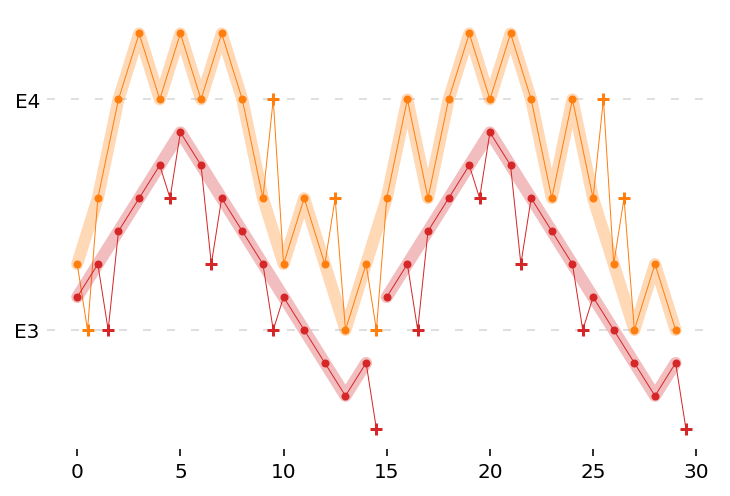

In [25]:
show_stream(tenor_pattern, color=tenor.color, mark_melismas=True)
show_stream(bass_pattern, color=bass.color, mark_melismas=True)
show_stream(bass_pattern, color=bass.color, mark_melismas=True, adjust_x=15)
show_octaves()
despine()

### Soprano

In [26]:
soprano_pattern_pitches  = 'G4 B4 G4 B4 E4 G4 E4 G4 E4 G4 E4 B4 G4 B4 G4 E5 G5 E5 B4 E5 G4 B4 G4 B4 E4 G4 B3 E4 '
soprano_pattern_pitches += 'G4 E4 B4 G4 B4 G4 E5 B4 E5 B4 E5'
soprano_pattern_pitches = soprano_pattern_pitches.split()
soprano_pattern = [music21.note.Note(pitch) for pitch in soprano_pattern_pitches]
melisma_indices = [3, 10, 14, 19, 23, 25, 29, 33, 38]
decorate_notes(soprano_pattern, melisma_indices);
# music21.stream.Stream(soprano_pattern).show()

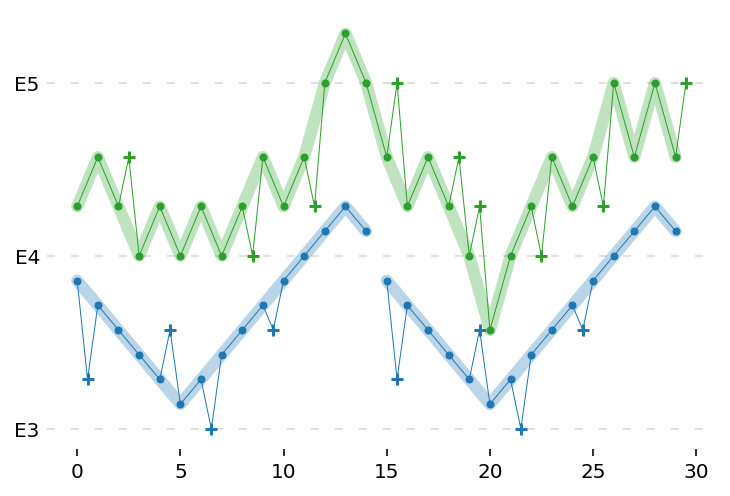

In [27]:
show_stream(soprano_pattern, color=soprano.color, mark_melismas=True)
show_stream(alto_pattern, color=alto.color, mark_melismas=True)
show_stream(alto_pattern, color=alto.color, mark_melismas=True, adjust_x=15)
show_octaves()
despine()

## Pattern repetitions

In [39]:
def plot_pattern_repetitions(part, pattern, color='C5', alto=None, bass=None, N=16, period=15):
    fix, axs = plt.subplots(N, 1, figsize=(.25 * period, .6 * N), tight_layout=True, gridspec_kw=dict(hspace=0))
    notes = []
    syllables = 0
    index = 0
    for n in range(len(part.flat.notes[1:])):
        note = part.flat.notes[1:][n]
        next_note = part.flat.notes[1:][n+1]
        
        if index >= N: break
        notes.append(note)

        if not note.editorial['melisma']:
            syllables += 1

        if syllables >= period and not next_note.editorial['melisma']:
            ax = axs[index]
            show_stream(pattern, color=color, ax=ax, 
                        mark_notes=False,
                        plot_notes=False,
                        melisma_plot_kws=dict(lw=5, alpha=.3),
                        skip_breaks=True, 
                        adjust_x=notes[0].editorial['relative_position'])

            show_stream(notes, color=color, 
                        plot_melismas=True, plot_notes=False, mark_melismas=True, 
                        skip_breaks=True, ax=ax)

            show_measures_without_breaks(alto=alto, bass=bass, ax=ax)
            show_sections_without_breaks(alto=alto, bass=bass, ax=ax)
            show_octaves(ax=axs[index])
            despine(ax=ax)
            index += 1
            syllables = 0
            notes = []
    return axs

# axs = plot_pattern_repetitions(alto, alto_pattern, color=alto.color, alto=True, N=6)

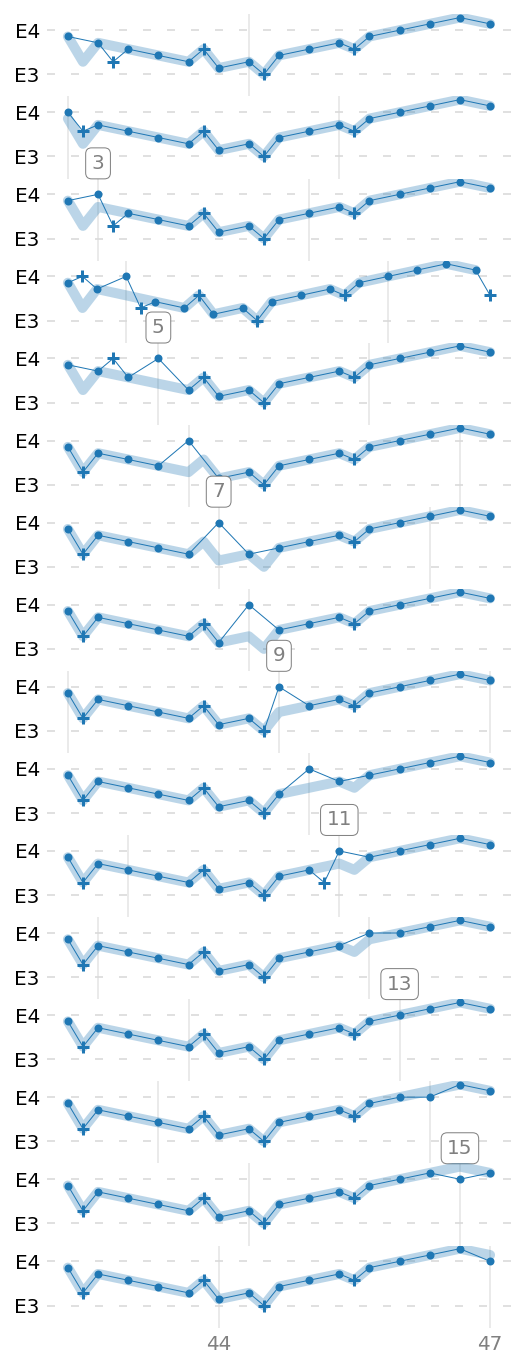

In [40]:
axs = plot_pattern_repetitions(alto, alto_pattern, color=alto.color, alto=True)
for ax in axs: ax.set_ylim(4.5, 17.5)
plt.savefig('../figures/pattern-repetitions/alto-repetitions.pdf')

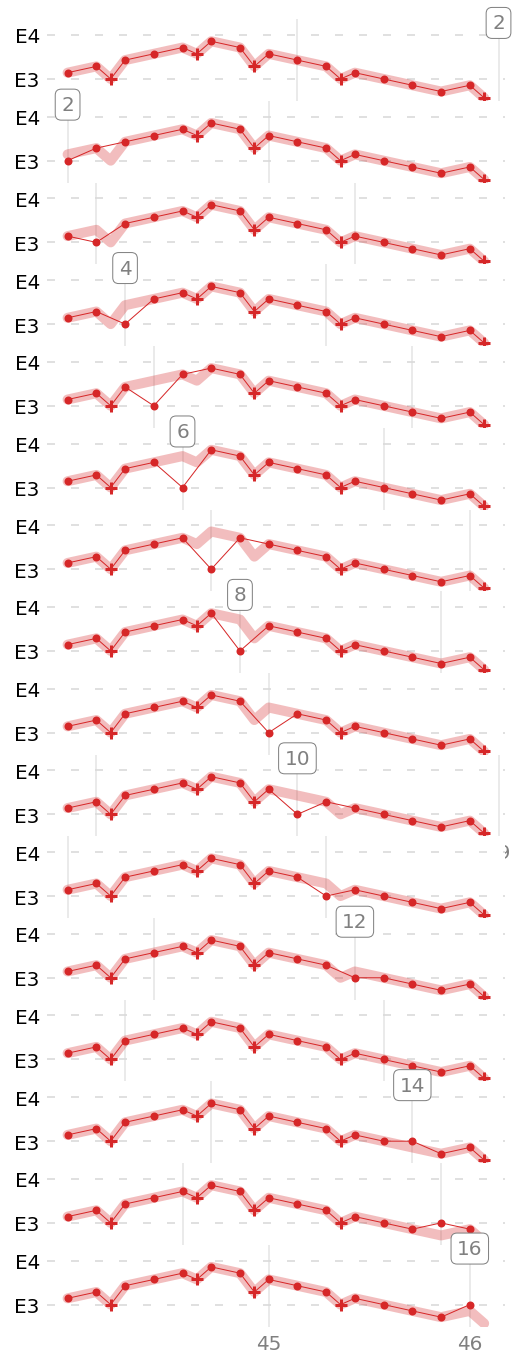

In [41]:
axs = plot_pattern_repetitions(bass, bass_pattern, color=bass.color, bass=True)
for ax in axs: ax.set_ylim(4.5, 17.5)
plt.savefig('../figures/pattern-repetitions/bass-repetitions.pdf')

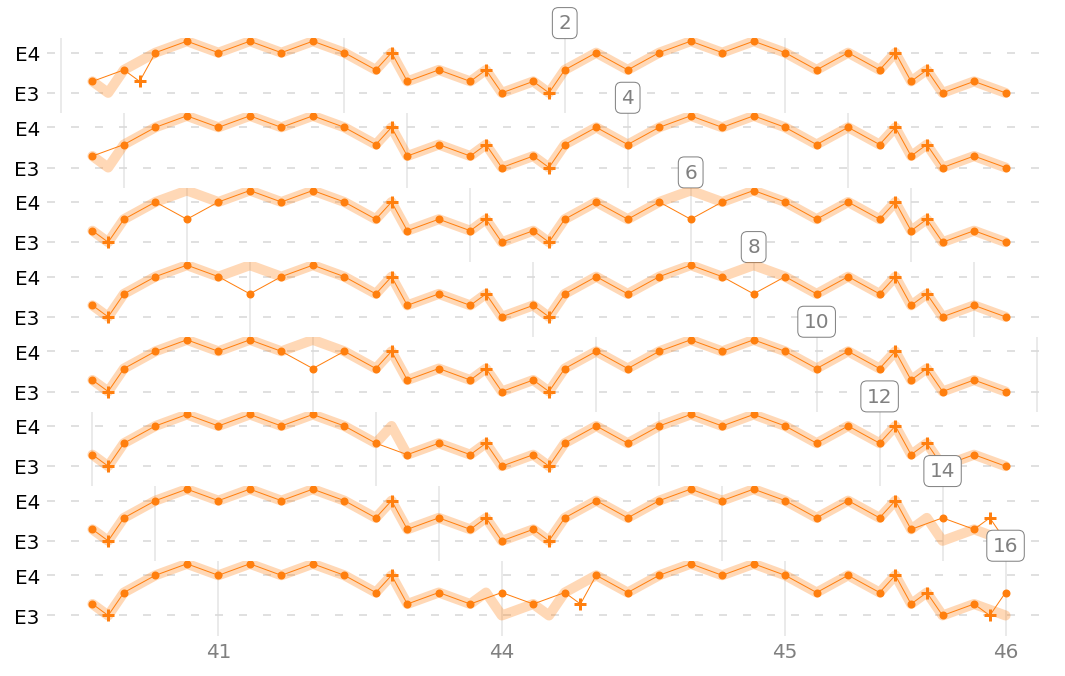

In [42]:
axs = plot_pattern_repetitions(tenor, tenor_pattern, color=tenor.color, bass=True, period=30, N=8)
for ax in axs: ax.set_ylim(4.5, 17.5)
plt.savefig('../figures/pattern-repetitions/tenor-repetitions.pdf')

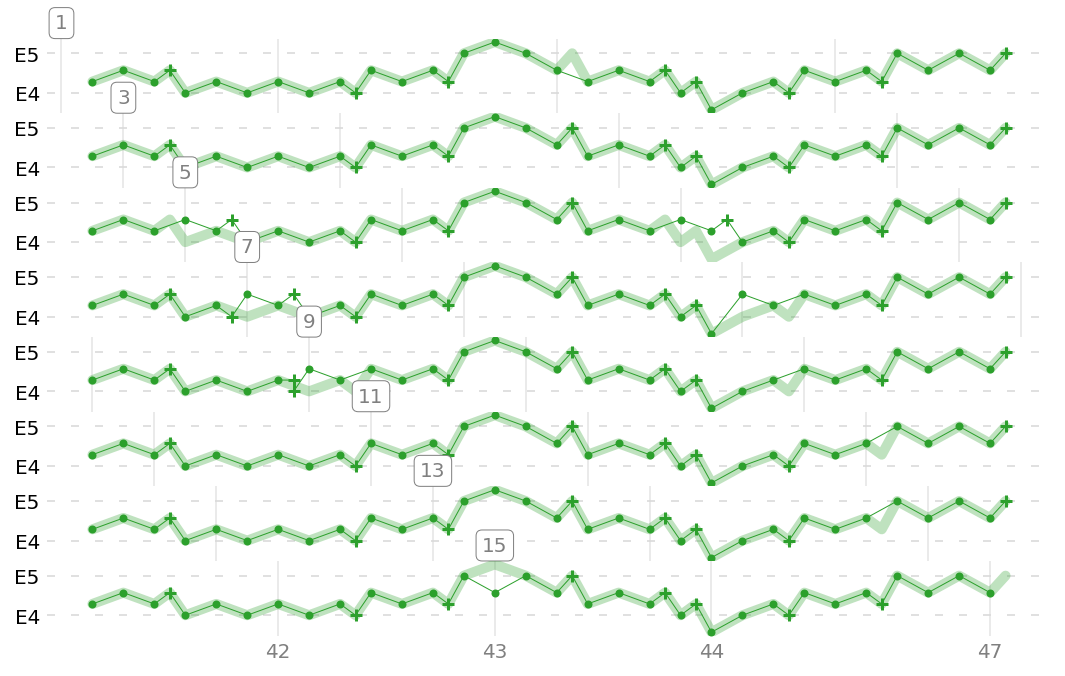

In [43]:
axs = plot_pattern_repetitions(soprano, soprano_pattern, color=soprano.color, alto=True, period=30, N=8)
plt.savefig('../figures/pattern-repetitions/soprano-repetitions.pdf')

## Melody and tintinnabuli voices

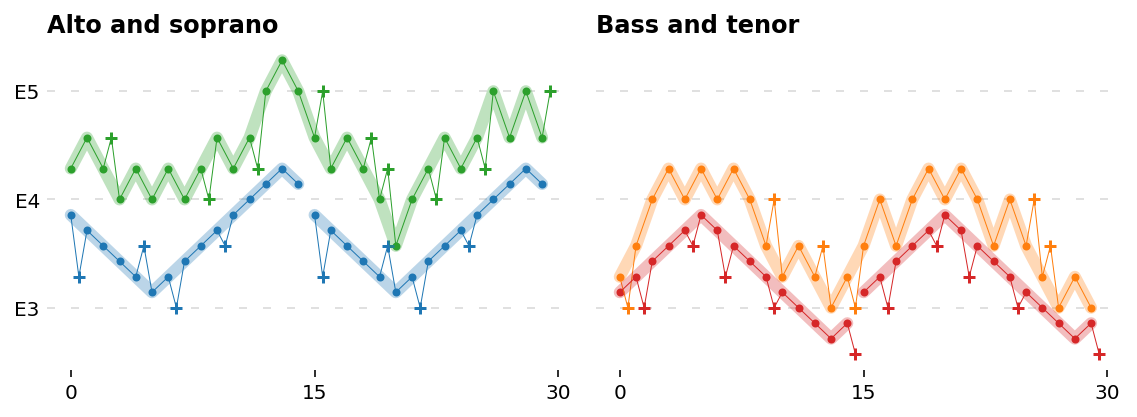

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True, sharey=True)

plt.sca(ax0)
show_stream(soprano_pattern, color=soprano.color, mark_melismas=True)
show_stream(alto_pattern, color=alto.color, mark_melismas=True)
show_stream(alto_pattern, color=alto.color, mark_melismas=True, adjust_x=15)
show_octaves()
plt.title('Alto and soprano', x=0, ha='left', fontweight='bold')
despine()
plt.xticks([0, 15, 30])

plt.sca(ax1)
show_stream(tenor_pattern, color=tenor.color, mark_melismas=True)
show_stream(bass_pattern, color=bass.color, mark_melismas=True)
show_stream(bass_pattern, color=bass.color, mark_melismas=True, adjust_x=15)
show_octaves()
despine()
plt.xticks([0, 15, 30])
plt.title('Bass and tenor', x=0, ha='left', fontweight='bold')
plt.ylim(4, 25)

plt.savefig('../figures/approximate-patterns/approximate-patterns.pdf')

## Does alto determine soprano?

In [ ]:
tintinnabuli = ['G2', 'B2', 'E3', 'G3', 'B3', 'E4', 'G4', 'B4', 'E5', 'G5', 'B5']
tintinnabuli = np.array([Note(n) for n in tintinnabuli])

In [ ]:
prev_index = None
sop = []
for ref in alto_pattern + alto_pattern:
    if ref.editorial['melisma']: continue
    candidates = np.where(tintinnabuli > ref)[0][1:]
    if prev_index is not None:
        candidates = np.intersect1d(candidates, [prev_index - 1, prev_index, prev_index + 1])
        candidates = np.setdiff1d(candidates, [prev_index])
        
    cur_index = candidates[0]
    cur = tintinnabuli[cur_index]
    sop.append(cur)
    prev_index = cur_index

In [ ]:
for a, b in zip(sop, [n for n in soprano_pattern if not n.editorial['melisma']]):
    print(a.nameWithOctave == b.nameWithOctave)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
prev_index = 4
ten = []
for ref in bass_pattern + bass_pattern + bass_pattern + bass_pattern:
    if ref.editorial['melisma']: continue
    candidates = np.where(tintinnabuli > ref)[0][0:]
    if prev_index is not None:
        candidates = np.intersect1d(candidates, [prev_index - 1, prev_index, prev_index + 1])
        candidates = np.setdiff1d(candidates, [prev_index])
        
    cur_index = candidates[0]
    cur = tintinnabuli[cur_index]
    ten.append(cur)
    prev_index = cur_index

In [ ]:
for a, b in zip(ten, [n for n in tenor_pattern if not n.editorial['melisma']]):
    print(a.nameWithOctave == b.nameWithOctave)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
